In [23]:
import os
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("open_api_key")

### 멀티모달 RAG 구현

데이터 전처리

In [ ]:
import nltk

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

In [ ]:
from unstructured.partition.pdf import partition_pdf
import os

fpath = r"pdf위치폴더경로"
fname = r"2025년 말라리아 주간소식지(27주차).pdf"

raw_pdf_elements = partition_pdf(
    filename = os.path.join(fpath,fname),
    extract_images_in_pdf = True,
    infer_table_structure=True,
    chunking_strategy = "by_title",
    extract_image_block_output_dir = r"이미지저장폴더경로",
)

In [54]:
print(raw_pdf_elements)

[<unstructured.documents.elements.CompositeElement object at 0x0000015109FF9940>, <unstructured.documents.elements.CompositeElement object at 0x0000015109FF86E0>, <unstructured.documents.elements.CompositeElement object at 0x00000151085E6900>, <unstructured.documents.elements.CompositeElement object at 0x0000015109FF82F0>, <unstructured.documents.elements.CompositeElement object at 0x00000151085E5710>, <unstructured.documents.elements.CompositeElement object at 0x00000151085E4C20>, <unstructured.documents.elements.TableChunk object at 0x00000151085E5F60>, <unstructured.documents.elements.TableChunk object at 0x00000151085E6350>, <unstructured.documents.elements.CompositeElement object at 0x00000151085E50F0>, <unstructured.documents.elements.CompositeElement object at 0x00000151085E51D0>, <unstructured.documents.elements.CompositeElement object at 0x00000151085E7230>, <unstructured.documents.elements.TableChunk object at 0x0000015108DCCE50>, <unstructured.documents.elements.TableChunk o

In [15]:
tables = []
texts = []
for elements in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(elements)):
        tables.append(str(elements))
    elif "unstructured.documents.elements.CompositeElement" in str(type(elements)):
        texts.append(str(elements))

In [19]:
tables[0]

'202444 (1. 1.~12. 31) A CHY|(272= HH|(2725) 202414 (1. 1.~7. 6) (1. 1.~7. 5.) Al 659 (100) 251 (100.0) 214 (100.0) A16.7 ae xt 551 (83.6) 213 (84.9) 168 (78.5) A211 O4Rt 108 (16.4) 38 (15.1) 46 (21.5) 21.1 ag 0-94 2 (0.3) 1 (0.4) 1 (0.5) 0.0 10-194 21 (3.2) 10 (4.0) 9 (4.2) A10.0 20-294 217 (32.9) 83 (33.1) 72 (33.6) A13.3 30-39 97 (14.7) 33 (13.1) 20 (9.3) 39.4 40-494 103 (15.6) 37 (14.7) 29 (13.6) A216 50-59 100 (15.2) 30 (12.0) 35 (16.4) 16.7 60-69 74 (11.2) 35 (13.9) 30 (14.0) A143'

In [20]:
texts[1]

'v fa 2! | Bat AS 38.2M(HS] 15-S8a/)O|GH, 20CH 72H(33.6%)O= 7 HRT, SOL (16.4%), GOCH 302(14.0%), 40CH 298(13.6%), 301 208(9.3%) rom By wo a (ed rm At\n\nv DIZH0l 1514(70.5%), HAAS! 38H(17.8%), MICS! 254(11.7%) AOR SAH JI 42\n\n> B7| 1268(68.9%), Cl 41B(19.2%), MES 22H(10.3%), GH 11B(5.1%), SAt 4B (1.9%), HAL, Bs, SS 2} 280.076), CHE, BE, CH, Bet 2} 120.5%) Oe wre\n\n— SSPE} Aa} Sle] SAZATIAS Z7| 1453(67.8%), CA 38H(17.8%), AH 153 (7.0%), MB 88C.7%) FOB BY, BANS BAS 8A(3.7%)\n\nBepeor oH7He7| Al SSt(26%)'

텍스트 테이블 요약

In [ ]:
# 텍스트 및 테이블 요약
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


prompts_text = """
    당신은 표와 텍스트를 요약하여 검색할 수 있도록 돕는 역할을 맡은 어시스턴트입니다.
    이 요약은 임베딩되어 원본 텍스트나 표 요소를 검색하는 데 사용될 것입니다.
    표 또는 텍스트에 대한 간결한 요약을 제공하여 검색에 최적화된 형태로 만들어 주세요.
    표 또는 텍스트 : {element}
"""

prompts = ChatPromptTemplate.from_template(prompts_text)

model = ChatOpenAI(temperature=0, model = "gpt-4", api_key=api_key)
summarize_chain = {"element" : lambda x : x}|prompts | model | StrOutputParser()

text_summaries = summarize_chain.batch(texts, {"max_concurrency" : 5})

table_summaries = summarize_chain.batch(tables, {"max_concurrency" : 5})

In [25]:
print(table_summaries[0])
print(text_summaries[0])

이 텍스트는 특정 기간 동안의 다양한 범위(0-94, 10-194, 20-294 등)에 대한 데이터를 제공합니다. 각 범위는 특정 수치(예: 2 (0.3), 21 (3.2), 217 (32.9) 등)를 가지며, 이는 아마도 해당 범위에 속하는 개체 또는 사건의 수를 나타내는 것으로 보입니다. 이 정보는 특정 기간 동안의 분포, 빈도, 또는 비율을 파악하는 데 사용될 수 있습니다.
이 텍스트는 주간 보고서에 대한 내용을 담고 있으나, 특정 정보나 데이터를 파악하기 어렵습니다. 표의 내용이 불분명하며, 텍스트는 불완전하고 혼란스러운 정보를 제공하고 있습니다. 이러한 형태로는 요약이나 검색 최적화가 어렵습니다. 원본 텍스트나 표의 명확한 정보가 필요합니다.


이미지 요약

In [ ]:
import base64
from langchain_core.messages import HumanMessage

def encode_image(image_path) -> str:
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')
    
img_base64_list = []
img_path = r"이미지폴더경로"

for img_file in sorted(os.listdir(img_path)):
    if img_file.endswith('.jpg'):
        path = os.path.join(img_path,img_file)
        base64_img = encode_image(path)
        img_base64_list.append(base64_img)

def image_summarize(img_base64:str) -> str:
    chat = ChatOpenAI(model="gpt-4o", api_key=api_key, max_tokens=1024)
    prompt = """
        당신은 이미지를 요약하여 검색을 위해 사용할 수 있도록 돕는 어시스턴트입니다.
        이 요약은 임베딩되어 원본 이미지를 검색하는 데 사용됩니다.
        이미지 검색에 최적화된 간결한 요약을 작성하세요.
    """

    msg = chat.invoke(
        [
            HumanMessage(
                content = [
                    {"type" : "text", "text":prompt},
                    {
                        "type" : "image_url",
                        "image_url" : {"url" : f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]

            )
        ]
        
    )
    return msg.content


image_summarizes = []

for img_base64 in img_base64_list:
    image_summary = image_summarize(img_base64)
    image_summarizes.append(image_summary)


In [42]:
image_summarizes

['"2025 말라리아 주간 소식지 표지, 27주차(6.29~7.5), 말라리아 감시 주간 보고서, 모기와 연구자 그림 포함, www.kdca.go.kr"',
 '질병관리청 로고, 태극 문양, KDCA 텍스트 포함.',
 '국내발생 및 해외유입에 따른 2021년부터 2025년까지의 발병 수 바 그래프. 각 연도별 국내발생과 해외유입 수치가 표시되어 있으며, 2023년에 가장 높은 수치를 기록함. 2025년 수치는 1주부터 27주까지 기록됨.',
 '2024년과 2025년의 주별 발생 수 비교 그래프. X축은 주차, Y축은 발생 수(명)를 나타냄. 2024년은 파란색, 2025년은 빨간색으로 표시됨. 2025년 초에 급증하고, 중반에 최고점을 이룸. 2024년에는 더 큰 변동이 있는 패턴을 보임.',
 '남녀 연령대별 발병 수 비교 바 차트: 2024년과 2025년 각 연령층(0-9세부터 70세 이상)에서의 남성과 여성 발병 수를 나타냄. 20-29세 남성의 발병이 두드러짐.',
 '말라리아 발생 분포 지도, 한국의 27주차 환자 수 컬러 코딩: 0-0 명(흰색), 0-1 명(연한 분홍색), 1-5 명(더 진한 분홍색), 5-12 명(연한 빨강), 12-52 명(진한 빨강). 북한 접경 지역에서 높은 발생.',
 '한국 지도에서 말라리아 발생 분포를 색으로 표시한 이미지. 북서쪽 지역에서 감염이 집중된 모습이며, 진한 빨간색일수록 높은 발생률을 나타냄.',
 '평년(2022~2024), 2024년, 2025년 매개모기 발생 추세 그래프. X축은 주 단위(4월-10월), Y축은 모기지수(개체 수 채집기수/일). 2025년은 낮은 모기지수 유지, 2024년은 6월 초 급증 후 감소, 평년은 완만한 증가 후 감소.',
 '```\n두 캐릭터가 있는 일러스트: 왼쪽 캐릭터는 모기기피제를 사용, 오른쪽 캐릭터는 활동 자제 표시. 배경에 "3시간마다 모기기피제 사용", "일몰 후부터 일출 전까지 활동 자제"라는 문구.\n```',
 '밝은색 긴 옷 착용, 야외활동 후 샤워

VectorDB 추가

In [43]:
from langchain.retrievers import MultiVectorRetriever
from langchain_core.stores import InMemoryStore
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings(api_key=api_key))
docstore = InMemoryStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore= vectorstore,
    docstore= docstore,
    id_key=id_key,
)

C:\Users\kimji\AppData\Local\Temp\ipykernel_2496\3789183265.py:6: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings(api_key=api_key))


In [44]:
import uuid

doc_ids = [str(uuid.uuid4()) for _ in texts]
retriever.docstore.mset(list(zip(doc_ids, texts)))

table_ids = [str(uuid.uuid4()) for _ in tables]
retriever.docstore.mset(list(zip(table_ids, tables)))

img_ids = [str(uuid.uuid4()) for _ in img_base64_list]
retriever.docstore.mset(list(zip(img_ids, img_base64_list)))

In [45]:
from langchain.schema.document import Document

summary_texts = [
    Document(page_content=s, metadata={id_key : doc_ids[i]})
    for i,s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)

summary_tables = [
    Document(page_content=s, metadata={id_key : table_ids[i]})
    for i,s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)

summary_img = [
    Document(page_content=s, metadata={id_key : img_ids[i]})
    for i,s in enumerate(image_summarizes)
]
retriever.vectorstore.add_documents(summary_img)



['f36fe3e2-1cb4-4ad6-a100-254b41efd6b6',
 'bd656dc5-759c-4a29-ad9a-6673ed9ea4ac',
 'd628c12a-06a5-4fe5-b083-98d79c9c0dc8',
 'd9a4da5c-ddb3-4cbd-8197-16abd343d29b',
 'bd4a5b6a-7a3c-4dab-8257-f64580b952fa',
 'c7eee61d-83b3-4a17-a90f-c7db0635f1f7',
 'cffaf7b5-4418-4013-b0cb-8cbacc83f548',
 '9f133a96-b038-4b45-a228-7c11532eef0b',
 'a0c5f799-aaae-4923-ad86-ae1234a6534b',
 '3d486cf4-f71f-4e32-a303-c1e2327738c6',
 '3491b6ea-a887-44be-803b-90ced194967b',
 '05e2259c-d0eb-494c-8fe4-14cdbaf7fa4d',
 '705c6d25-bb49-4aac-84a5-0b4a3ea1d48b',
 '0401f94f-596a-495a-aa39-c7da3a327443',
 '410334ad-7706-4d9a-a536-6703ae24038c',
 '8e7c065c-a85f-4f22-89f4-9161e22be2b4',
 '44f7da85-7ca4-414d-8418-99a0b89dba64',
 '72d22127-6cff-4fa8-8437-ee9a898dbb43',
 '7b940f09-d20f-46f4-bd26-3736b762acb6']

검색확인

In [46]:
docs = retriever.invoke("말라리아 군집 사례는 어떤 건가요?")
print(len(docs))

4


In [47]:
from base64 import b64decode
def split_image_text_types(docs):
    b64 = []
    text=[]
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    
    return {
        "images" : b64,
        "texts" : text
    }

docs_by_type = split_image_text_types(docs)

print(len(docs_by_type["images"]))
print(len(docs_by_type["texts"]))

4
0



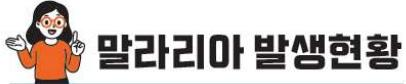

In [48]:
from IPython.display import display, HTML

def plt_img_base64(img_base64):
    image_html = f'<img src ="data:image/jpeg;base64,{img_base64}"/>'
    display(HTML(image_html))

plt_img_base64(docs_by_type["images"][0])

In [49]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    text = f"""
        다음 문맥에만 기반하여 질문에 답하세요. 문맥에는 텍스트, 표, 그리고 아래 이미지가 포함될 수 있습니다.
        질문 : {dict["question"]}
        텍스트와 표 : {format_texts}
    """

    prompt = [
        HumanMessage(
            content = [
                {"type" : "text", "text":text},
                {"type" : "image_url", "image_url" : {"url" : f"data:image/jpeg;base64,{dict['context']['images'][0]}"}},            
            ],
        )
    ]

    return prompt


model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=1024,api_key=api_key)

chain = (
    {"context" : retriever | RunnableLambda(split_image_text_types), "question" : RunnablePassthrough()}
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

chain.invoke("말라리아 군집 사례는 어떤가요?")

'말라리아 군집 사례에 대한 정보는 제공된 문맥에 포함되어 있지 않습니다. 추가적인 세부사항이 필요합니다.'

In [50]:
chain.invoke("말라리아 국내 발생 건수는 어느정도야?")

'이미지에 따르면, 말라리아 국내 발생 건수는 지역에 따라 다르며, 0에서 52건 사이입니다. 특히, 북서부 지역에서 발생 건수가 높은 것으로 보입니다.'

In [51]:
chain.invoke("해외여행시 주의할 점은?")

'해외여행 시 주의할 점은 모기 등 해충에 물리지 않도록 주의하는 것입니다. 이미지에서 여행객들이 모기 퇴치 스프레이를 사용하는 모습이 보입니다. 따라서 모기 기피제를 사용하거나 적절한 옷차림을 통해 해충으로부터 보호하는 것이 중요합니다.'